#PTI: Pivotal Tuning for StyleGAN

In [12]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

download_with_pydrive = True  

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()
        
    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)
    
    def download_file(self, file_id, file_dst):
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)

## Step 1 - Install Packages required by PTI

In [ ]:
!pip install -q wandb lpips
# Used for faster inference of StyleGAN by enabling C++ code compilation
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

## Step 2 - Download Pretrained models

In [2]:
import os
os.chdir('/content')
CODE_DIR = 'PTI'

In [ ]:
!git clone https://github.com/danielroich/PTI.git $CODE_DIR

In [4]:
os.chdir(f'./{CODE_DIR}')

In [9]:
import os
import sys
import pickle
import numpy as np
from PIL import Image
import torch
from configs import paths_config, hyperparameters, global_config
from utils.align_data import pre_process_images
from scripts.run_pti import run_PTI
from IPython.display import display
import matplotlib.pyplot as plt
from scripts.latent_editor_wrapper import LatentEditorWrapper

In [10]:
current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), CODE_DIR, "pretrained_models")
os.makedirs(save_path, exist_ok=True)

In [13]:
## Download pretrained StyleGAN on FFHQ 1024x1024
downloader.download_file("125OG7SMkXI-Kf2aqiwLLHyCvSW-gZk3M", os.path.join(save_path, 'ffhq.pkl'))

In [14]:
## Download Dlib tool for alingment, used for preprocessing images before PTI
downloader.download_file("1xPmn19T6Bdd-_RfCVlgNBbfYoh1muYxR", os.path.join(save_path, 'align.dat'))

## Step 3 - Configuration Setup

In [15]:
image_dir_name = 'image'

## If set to true download desired image from given url. If set to False, assumes you have uploaded personal image to
## 'image_original' dir
use_image_online = True
image_name = 'personal_image'
use_multi_id_training = False
global_config.device = 'cuda'
paths_config.e4e = '/content/PTI/pretrained_models/e4e_ffhq_encode.pt'
paths_config.input_data_id = image_dir_name
paths_config.input_data_path = f'/content/PTI/{image_dir_name}_processed'
paths_config.stylegan2_ada_ffhq = '/content/PTI/pretrained_models/ffhq.pkl'
paths_config.checkpoints_dir = '/content/PTI/'
paths_config.style_clip_pretrained_mappers = '/content/PTI/pretrained_models'
hyperparameters.use_locality_regularization = False

## Step 4 - Preproccess Data

In [16]:
os.makedirs(f'./{image_dir_name}_original', exist_ok=True)
os.makedirs(f'./{image_dir_name}_processed', exist_ok=True)
os.chdir(f'./{image_dir_name}_original')

In [ ]:
if use_image_online:
  !wget -O personal_image.jpg https://yt3.ggpht.com/e618aNRXbKkfoeGVZBtl5cF587IIl3eY8xeYTI_wrYZw1evujw6AoaYkTtNJfNfvnGnoWoY-uQ=s900-c-k-c0x00ffffff-no-rj

In [46]:
original_image = Image.open(f'{image_name}.jpg')

In [47]:
os.chdir('/content/PTI')

In [48]:
pre_process_images(f'/content/PTI/{image_dir_name}_original')

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


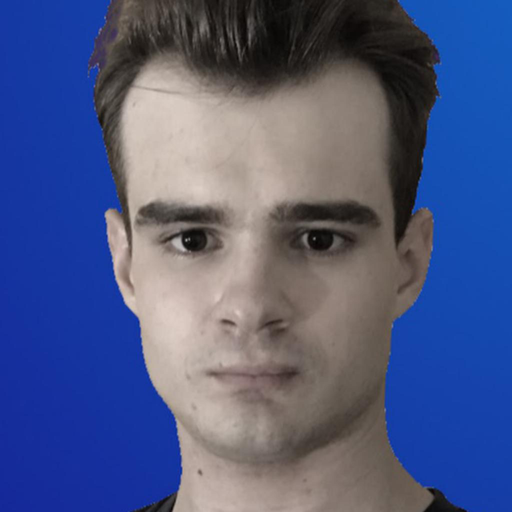

In [49]:
aligned_image = Image.open(f'/content/PTI/{image_dir_name}_processed/{image_name}.jpeg')
aligned_image.resize((512, 512))

## Step 5 - Invert images using PTI

In [ ]:
os.chdir('/content/PTI')
model_id = run_PTI(use_wandb=False, use_multi_id_training=use_multi_id_training)

## Visualize results

In [51]:
def display_alongside_source_image(images): 
    res = np.concatenate([np.array(image) for image in images], axis=1) 
    return Image.fromarray(res) 

def load_generators(model_id, image_name):
  with open(paths_config.stylegan2_ada_ffhq, 'rb') as f:
    old_G = pickle.load(f)['G_ema'].cuda()
    
  with open(f'{paths_config.checkpoints_dir}/model_{model_id}_{image_name}.pt', 'rb') as f_new: 
    new_G = torch.load(f_new).cuda()

  return old_G, new_G

In [53]:
generator_type = paths_config.multi_id_model_type if use_multi_id_training else image_name
old_G, new_G = load_generators(model_id, generator_type)

In [54]:
def plot_syn_images(syn_images): 
  for img in syn_images: 
      img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).detach().cpu().numpy()[0] 
      plt.axis('off') 
      resized_image = Image.fromarray(img,mode='RGB').resize((256, 256)) 
      display(resized_image) 
      del img 
      del resized_image 
      torch.cuda.empty_cache()

If multi_id_training was used for several images.
You can alter the w_pivot index which is currently configured to 0, and then running
the visualization code again. Using the same generator on different latent codes.

Upper image is the inversion before Pivotal Tuning and the lower image is the product of pivotal tuning


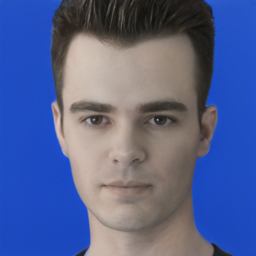

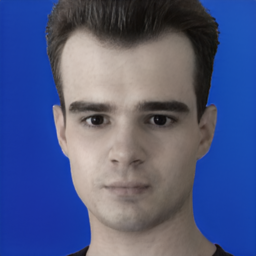

In [55]:
w_path_dir = f'{paths_config.embedding_base_dir}/{paths_config.input_data_id}'
embedding_dir = f'{w_path_dir}/{paths_config.pti_results_keyword}/{image_name}'
w_pivot = torch.load(f'{embedding_dir}/0.pt')

old_image = old_G.synthesis(w_pivot, noise_mode='const', force_fp32 = True)
new_image = new_G.synthesis(w_pivot, noise_mode='const', force_fp32 = True)

plot_syn_images([old_image, new_image])

## InterfaceGAN edits

In [56]:
latent_editor = LatentEditorWrapper()
latents_after_edit = latent_editor.get_single_interface_gan_edits(w_pivot, [-2, 2])

In order to get different edits. Such as younger face or make the face smile more. Please change the factors passed to "get_single_interface_gan_edits".
Currently the factors are [-2,2]. You can pass for example: range(-3,3)

Showing rotation change


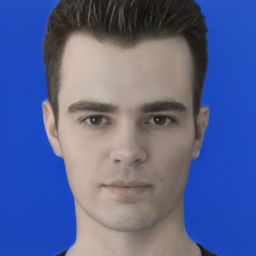

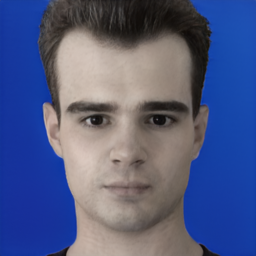

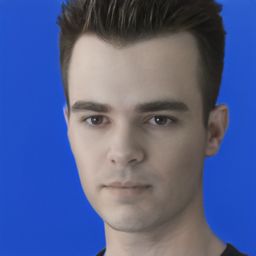

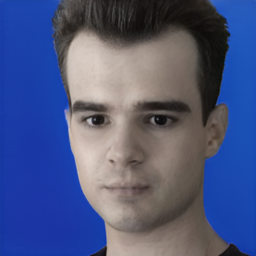

Showing smile change


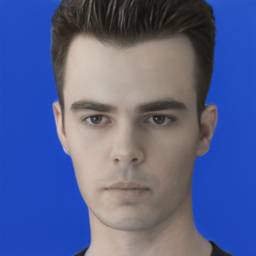

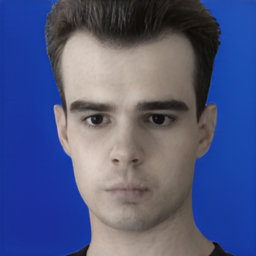

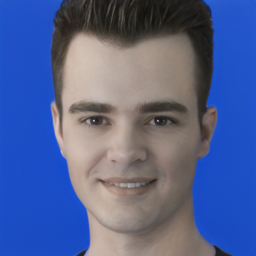

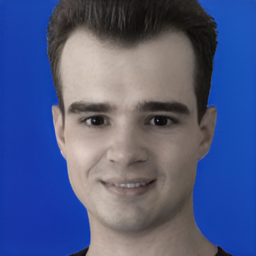

Showing age change


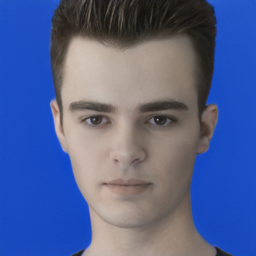

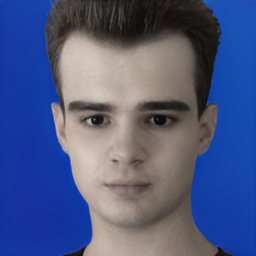

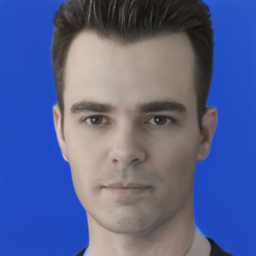

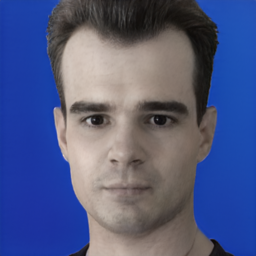

In [57]:
for direction, factor_and_edit in latents_after_edit.items():
  print(f'Showing {direction} change')
  for latent in factor_and_edit.values():
    old_image = old_G.synthesis(latent, noise_mode='const', force_fp32 = True)
    new_image = new_G.synthesis(latent, noise_mode='const', force_fp32 = True)
    plot_syn_images([old_image, new_image])

## StyleCLIP editing

### Download pretrained models

In [75]:
mappers_base_dir = '/content/PTI/pretrained_models'
# More pretrained mappers can be found at: "https://github.com/orpatashnik/StyleCLIP/blob/main/utils.py"
# Download mappers
downloader.download_file("1i5vAqo4z0I-Yon3FNft_YZOq7ClWayQJ", os.path.join(mappers_base_dir, 'afro.pt'))
downloader.download_file("1oMMPc8iQZ7dhyWavZ7VNWLwzf9aX4C09", os.path.join(mappers_base_dir, 'mohawk.pt'))
downloader.download_file("1xZ7fFB12Ci6rUbUfaHPpo44xUFzpWQ6M", os.path.join(mappers_base_dir, 'curly_hair.pt'))
downloader.download_file("1g82HEH0jFDrcbCtn3M22gesWKfzWV_ma", os.path.join(mappers_base_dir, 'angry.pt'))
downloader.download_file("1F-mPrhO-UeWrV1QYMZck63R43aLtPChI", os.path.join(mappers_base_dir, 'surprised.pt'))
# Download e4e encoder, used for the first inversion step instead on the W inversion.
downloader.download_file("1cUv_reLE6k3604or78EranS7XzuVMWeO", os.path.join(mappers_base_dir, 'e4e_ffhq_encode.pt'))

### Use PTI with e4e backbone for StyleCLIP

In [ ]:
# Changing first_inv_type to W+ makes the PTI use e4e encoder instead of W inversion in the first step
hyperparameters.first_inv_type = 'w+'
os.chdir('/content/PTI')
model_id = run_PTI(use_wandb=False, use_multi_id_training=use_multi_id_training)

### Apply edit

In [77]:
from scripts.pti_styleclip import styleclip_edit

paths_config.checkpoints_dir = '/content/PTI'
os.chdir('/content/PTI')
styleclip_edit(use_multi_id_G=use_multi_id_training, run_id=model_id, edit_types=['afro'], use_wandb=False)
styleclip_edit(use_multi_id_G=use_multi_id_training, run_id=model_id, edit_types=['mohawk'], use_wandb=False)
styleclip_edit(use_multi_id_G=use_multi_id_training, run_id=model_id, edit_types=['angry'], use_wandb=False)
styleclip_edit(use_multi_id_G=use_multi_id_training, run_id=model_id, edit_types=['surprised'], use_wandb=False)

Loading from checkpoint: /content/PTI/pretrained_models/afro.pt
Loading from checkpoint: /content/PTI/pretrained_models/mohawk.pt
Loading from checkpoint: /content/PTI/pretrained_models/angry.pt
Loading from checkpoint: /content/PTI/pretrained_models/surprised.pt


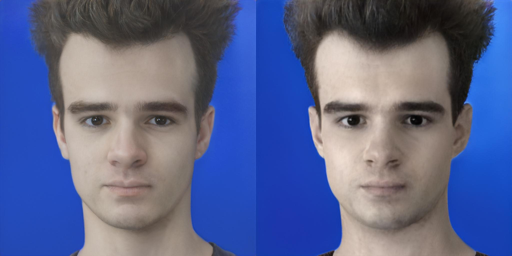

In [83]:
def show_sample(feature):
  original_styleCLIP_path = f'/content/PTI/StyleCLIP_results/{image_dir_name}/{image_name}/e4e/{image_name}_{feature}.jpg'
  new_styleCLIP_path  = f'/content/PTI/StyleCLIP_results/{image_dir_name}/{image_name}/PTI/{image_name}_{feature}.jpg'
  original_styleCLIP = Image.open(original_styleCLIP_path).resize((256, 256))
  new_styleCLIP =  Image.open(new_styleCLIP_path).resize((256, 256))
  return display_alongside_source_image([original_styleCLIP, new_styleCLIP])

show_sample('afro')

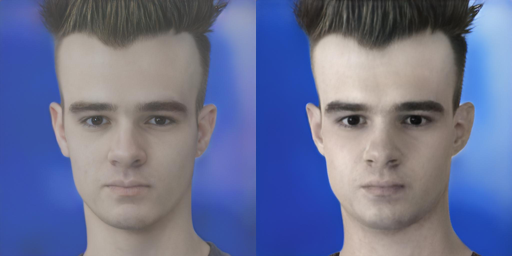

In [84]:
show_sample('mohawk')

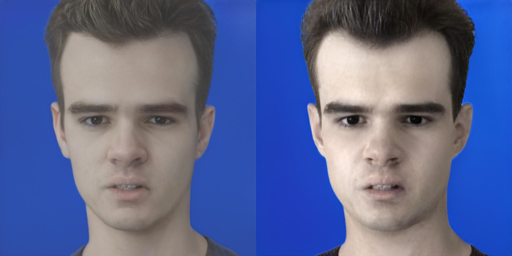

In [85]:
show_sample('angry')

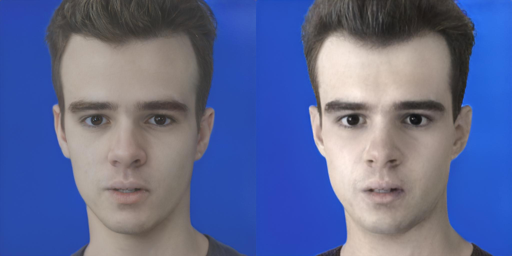

In [86]:
show_sample('surprised')

## Other methods comparison

### Invert image using other methods

In [87]:
from scripts.latent_creators import e4e_latent_creator
from scripts.latent_creators import sg2_latent_creator
from scripts.latent_creators import sg2_plus_latent_creator

In [88]:
e4e_latent_creator = e4e_latent_creator.E4ELatentCreator()
e4e_latent_creator.create_latents()
sg2_latent_creator = sg2_latent_creator.SG2LatentCreator(projection_steps=600)
sg2_latent_creator.create_latents()
sg2_plus_latent_creator = sg2_plus_latent_creator.SG2PlusLatentCreator(projection_steps=1200)
sg2_plus_latent_creator.create_latents()

Loading e4e over the pSp framework from checkpoint: /content/PTI/pretrained_models/e4e_ffhq_encode.pt


100%|██████████| 1/1 [04:36<00:00, 276.02s/it]


In [89]:
inversions = {}
sg2_embedding_dir = f'{w_path_dir}/{paths_config.sg2_results_keyword}/{image_name}'
inversions[paths_config.sg2_results_keyword] = torch.load(f'{sg2_embedding_dir}/0.pt')
e4e_embedding_dir = f'{w_path_dir}/{paths_config.e4e_results_keyword}/{image_name}'
inversions[paths_config.e4e_results_keyword] = torch.load(f'{e4e_embedding_dir}/0.pt')
sg2_plus_embedding_dir = f'{w_path_dir}/{paths_config.sg2_plus_results_keyword}/{image_name}'
inversions[paths_config.sg2_plus_results_keyword] = torch.load(f'{sg2_plus_embedding_dir}/0.pt')

In [90]:
def get_image_from_w(w, G):
  if len(w.size()) <= 2:
      w = w.unsqueeze(0) 
  img = G.synthesis(w, noise_mode='const', force_fp32=True) 
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).detach().cpu().numpy() 
  return img[0] 

In [91]:
def plot_image_from_w(w, G): 
  img = get_image_from_w(w, G) 
  plt.axis('off') 
  resized_image = Image.fromarray(img,mode='RGB').resize((256,256)) 
  display(resized_image) 

Displaying SG2 inversion


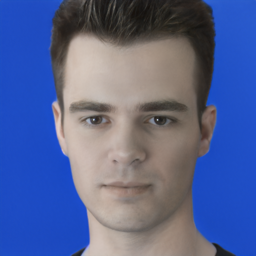

Displaying e4e inversion


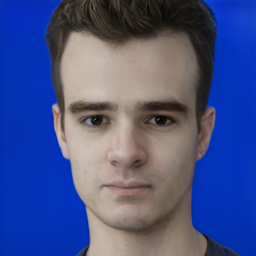

Displaying SG2_plus inversion


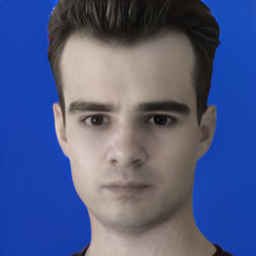

Displaying PTI inversion


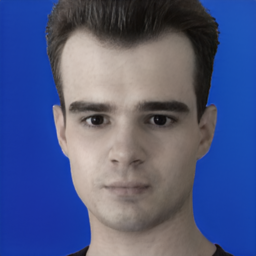

In [92]:
for inv_type, latent in inversions.items():
  print(f'Displaying {inv_type} inversion')
  plot_image_from_w(latent, old_G)
print(f'Displaying PTI inversion')
plot_image_from_w(w_pivot, new_G)